# 精神病に関するアンケート結果の解析

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model as lm
from sklearn.metrics import confusion_matrix
from collections import OrderedDict

## データ概観

In [2]:
df_raw = pd.read_csv('./survey.csv')
pandas_profiling.ProfileReport(df_raw)

Number of variables,27
Number of observations,1259
Total Missing (%),5.6%
Total size in memory,265.6 KiB
Average record size in memory,216.1 B
Numeric,1
Categorical,26
Boolean,0
Date,0
Text (Unique),0
Rejected,0


一見して以下の事がわかる。
- Ageに外れ値がある
- Genderの名寄せが必要
- work_interfere、commentsは無効値が多い
- アメリカ合衆国以外の(stateの記載がない)回答が約40%

## 方針
##### treatment（精神病の治療を受けたことがあるか）を目的変数とする
1. 年齢が外れ値の項目を削除
1. 性別を名寄せ
1. 雇用形態の回答の無効値を削除
1. 今回は簡単のため、扱いずらい項目は思い切って削除する
1. 各項目とtreatmentの関係を目視し、説明変数を決定する

In [3]:
df = df_raw.copy()

#### 年齢が異常値（0歳以下、120歳以上）のデータを削除

In [4]:
# 年齢が異常値の行を削除
drop_list = []
for index, row in df.iterrows():
    if int(row['Age']) < 0 or int(row['Age']) > 120:
        drop_list.append(index)
df.drop(drop_list, inplace=True)

#### 性別の名寄せ（男性、女性、その他）

In [5]:
df.loc[df['Gender'].str.lower().str.contains('^(cis)*.*(female|woman|f|femail).?$'), 'Gender'] = 'F'
df.loc[df['Gender'].str.lower().str.contains('^female \(cis\)$'), 'Gender'] = 'F'
df.loc[df['Gender'].str.lower().str.contains('^(cis)*.*(male|man|m|make|mail).?$'), 'Gender'] = 'M'
df.loc[df['Gender'].str.lower().str.contains('^(male \(cis\)|mal)$'), 'Gender'] = 'M'
df.loc[~df['Gender'].str.contains('(^(F|M)$)'),'Gender'] = 'other'

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


#### 無効値を"no_data"で置き換え

In [6]:
df.fillna({'self_employed':'no_data', 'state':'no_data', 'work_interfere':'no_data'}, inplace=True)

#### その他
- 回答日時を年のみに変更
- コメントありの場合、"existence"とする
- アメリカ以外の国の場合は州を"no_data"にする

In [7]:
df.replace('-[0-9]+-[0-9]+ .*', '', regex=True, inplace=True)
df.fillna({'comments':'none'}, inplace=True)
df.loc[df['comments'] != 'none', 'comments'] = 'existence'
df.loc[df['Country'] != 'United States', 'state'] = 'no_data'

## treatment との関係を確認

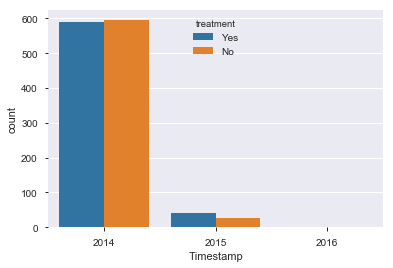

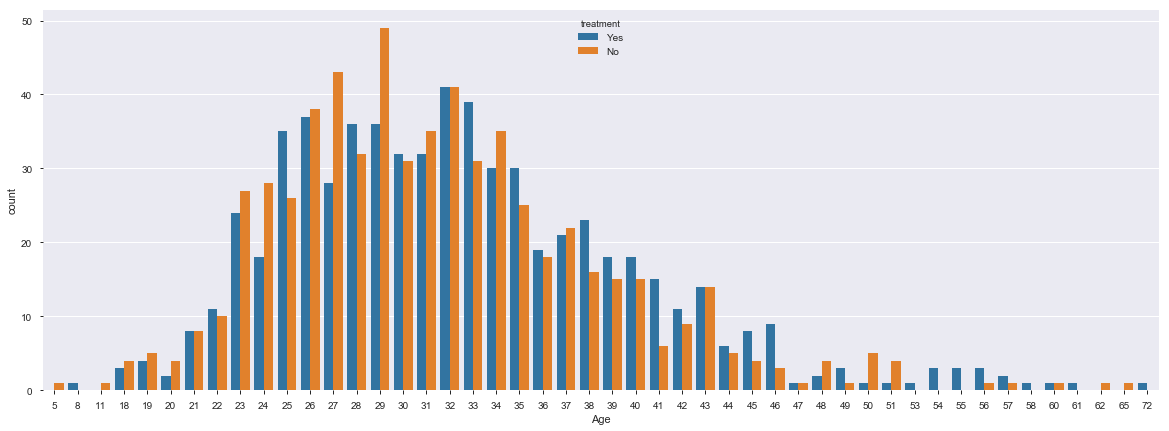

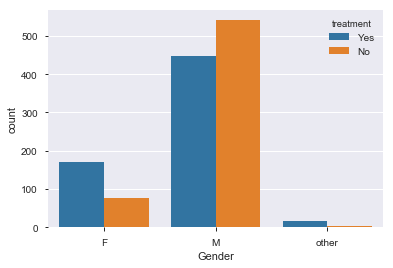

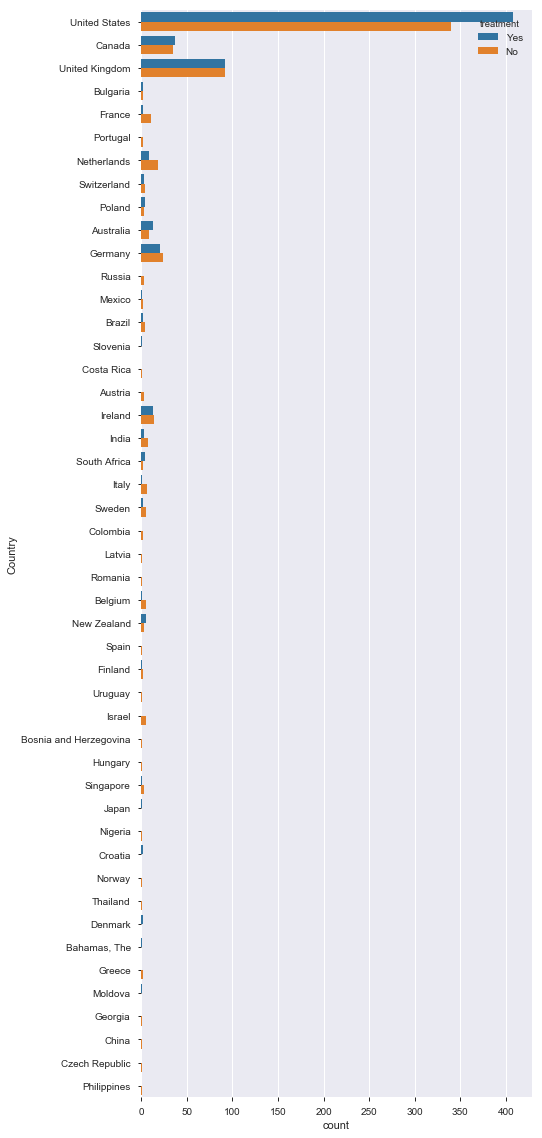

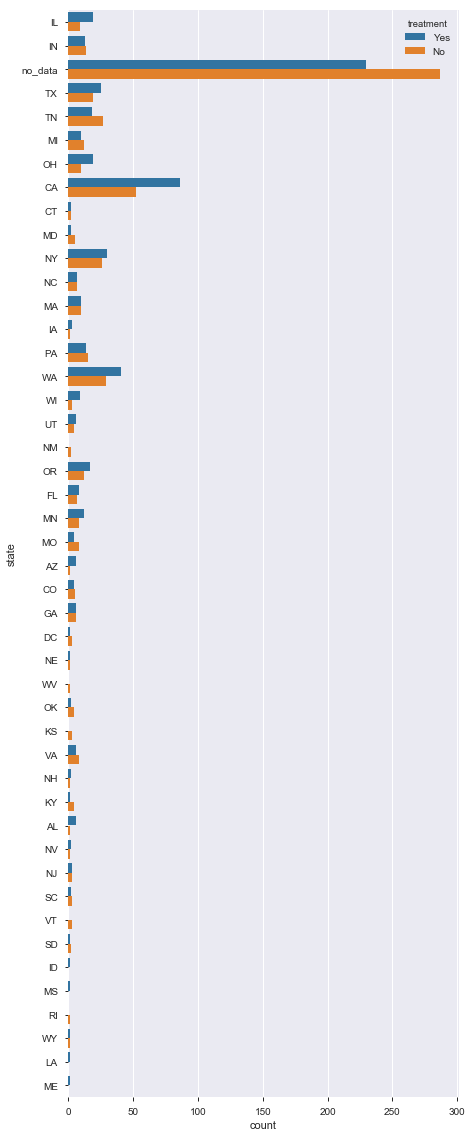

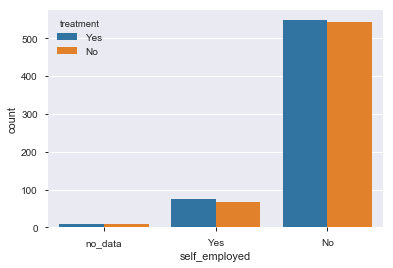

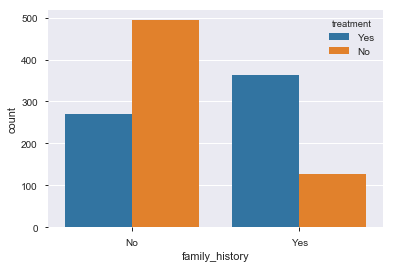

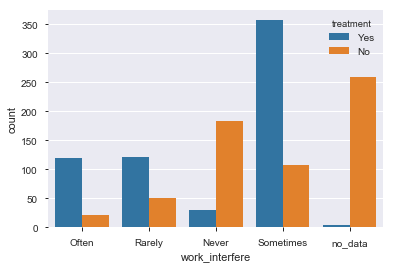

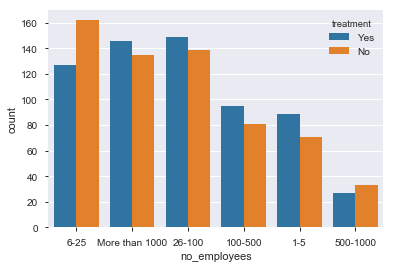

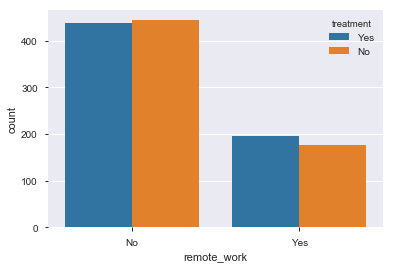

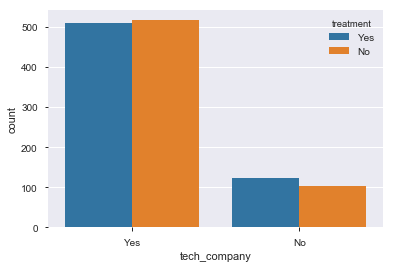

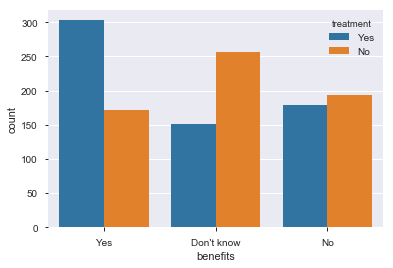

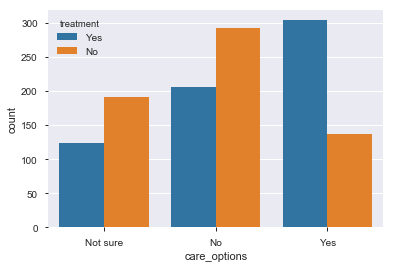

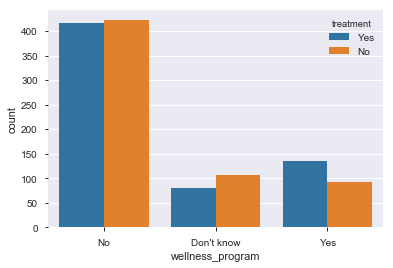

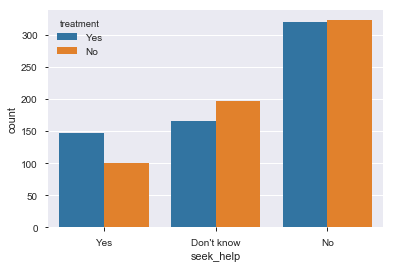

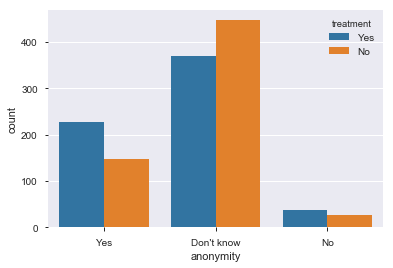

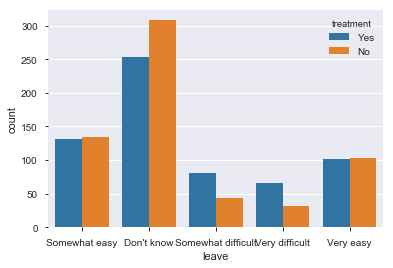

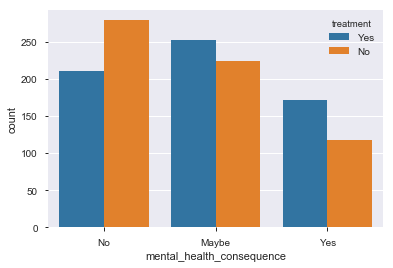

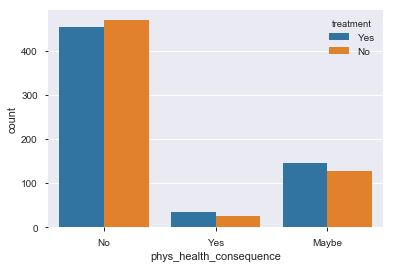

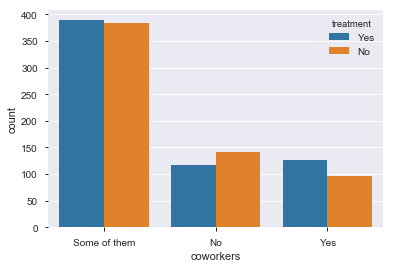

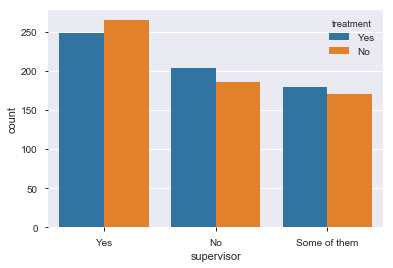

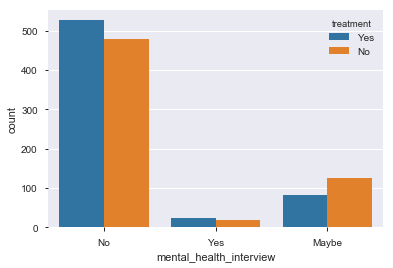

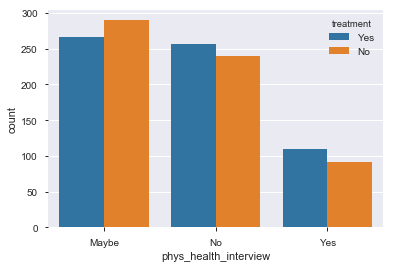

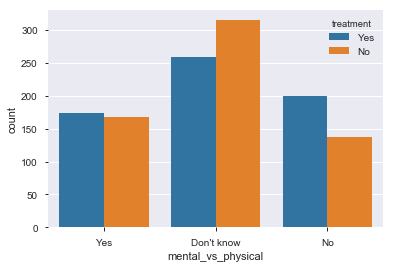

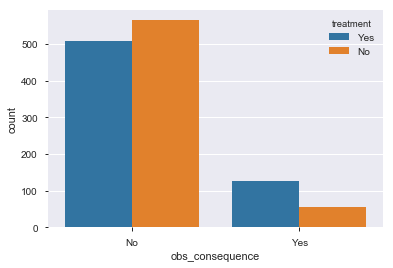

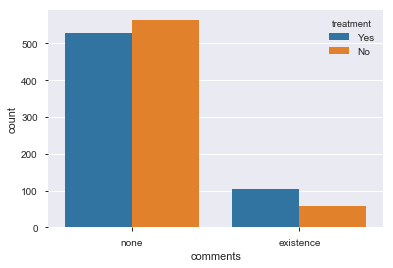

In [8]:
%matplotlib inline
    
for col in df.columns:
#     if col not in check_list:
#         continue
    if col == 'treatment':
        continue
    if col == 'Country' or col == 'state':
        plt.figure(figsize=(7, 20))
        sns.countplot(y=col, hue='treatment', hue_order=df['treatment'].unique(), data=df)
    else:
        if col == 'Age':
            plt.figure(figsize=(20, 7))
        sns.countplot(x=col, hue='treatment', hue_order=df['treatment'].unique(), data=df)
    plt.show()   

## モデル作成準備
### 学習データ設定
ダミー変数化＆訓練/評価データを分割する関数を用意する。  
精度比較のため、"train_test_split"のランダム変数の種を0固定する。

In [9]:
def make_dataset(df_exp, df_res, test_ratio):
    bi_list = []
    for column in df_exp.columns: 
        if df_exp[column].nunique() < 3:
            bi_list.append(column)
    for c in bi_list:
        col = df_exp.columns.tolist()
        col.remove(c)
        col.append(c)
        df_exp_proc = df_exp.ix[:,col]

    df_exp_proc = pd.get_dummies(df_exp_proc)
    df_res_proc = pd.get_dummies(df_res)

    x = df_exp_proc#.as_matrix
    y = df_res_proc['Yes']#.as_matrix
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
#     print(y_test[:10])
    return X_train, X_test, y_train, y_test

### 認識器設定
複数の手法（ロジスティック回帰、ニューラルネットワーク以外）でグリッドサーチを行い、  
その結果得られたAccuracyをスコアとして返す関数を用意する。  
参考のためランダムフォレストの影響度のグラフを出力する。

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras import optimizers

def NN(X_train, X_test, y_train, y_test):
    y_train_ = []
    for tmp in y_train:
        if tmp == 1:
            y_train_.append([0, 1])
        else:
            y_train_.append([1, 0])
    y_train = pd.DataFrame(y_train_)
    y_test_ = []
    for tmp in y_test:
        if tmp == 1:
            y_test_.append([0, 1])
        else:
            y_test_.append([1, 0])
    y_test = pd.DataFrame(y_test_)

    model = Sequential([
        Dense(50, input_shape=(len(X_train.columns),)),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(2),
        Activation('softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=100, validation_split=0.1)
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Test Accuracy = ', score[1])
    return score[1]

Using TensorFlow backend.


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm

def classifiers(X_train, X_test, y_train, y_test, cv_num=5):

    results = {'ロジスティック回帰': 0, '決定木': 0,  'バギング': 0, 
                'ランダムフォレスト': 0, 'アダブースト': 0, 
                'K近傍法': 0, 'SVM': 0}


    print('ニューラルネット')
    results['ニューラルネット'] = NN(X_train, X_test, y_train, y_test)
    
    # ロジスティック回帰
    print('ロジスティック回帰')
    clf = lm.LogisticRegression()
    clf.fit (X_train, y_train)
    y_pred_clf = clf.predict(X_test)
    max_acc = 0
    max_thr = 0
    y_test_value = y_test.values
    for i in range(1, 10, 1):
        thr = i * 0.1
        y_pred_clf = clf.predict(X_test)
        y_pred_clf[y_pred_clf < thr] = 0
        y_pred_clf[y_pred_clf >= thr] = 1
        cm = confusion_matrix(y_test_value, y_pred_clf)
        acc = (cm[0][0]+cm[1][1]) / (np.array(cm).sum())
        if acc > max_acc:
            max_acc = acc
            max_thr = i * 0.1
    print('Threshold : ', end='')
    print(max_thr)
    y_pred_clf[y_pred_clf < max_thr] = 0
    y_pred_clf[y_pred_clf >= max_thr] = 1
    y_test_value = y_test.values
    cm = confusion_matrix(y_test_value, y_pred_clf)
#     print('Confusion Matrix : ')
#     print(cm)
    print('Accuracy = ', end='')
    print((cm[0][0]+cm[1][1]) / (np.array(cm).sum()))
#     print('Recall of Yes = ', end='')
#     print(cm[1][1] / (cm[1][0]+cm[1][1]))
#     print('Precision of Yes = ', end='')
#     print(cm[1][1] / (cm[0][1]+cm[1][1]))
    results['ロジスティック回帰'] = (cm[0][0]+cm[1][1]) / (np.array(cm).sum())
    print('')
    
    print('決定木')
    tuned_parameters = [{'max_depth':[5,10, 20, 30], 'max_features':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_tree = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_tree.fit(X_train, y_train) 
    result_best = clf_gs_cv_tree.best_params_
    print('Train Accuracy =', clf_gs_cv_tree.best_score_, clf_gs_cv_tree.best_params_)
    predicted_labels = clf_gs_cv_tree.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['決定木'] = score
    print('')

    print('バギング')
#     tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'max_features':[0.4, 0.6, 0.8, 1.0], 'max_samples':[0.4, 0.6, 0.8, 1.0]}]
    tuned_parameters = [{'n_estimators':[30, 50, 80, 100], 'max_features':[0.4, 0.6, 1.0], 'max_samples':[0.4, 0.8, 1.0]}]
    clf_gs_cv_bagging = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_bagging.fit(X_train, y_train) 
    result_best = clf_gs_cv_bagging.best_params_
    print('Train Accuracy =', clf_gs_cv_bagging.best_score_, clf_gs_cv_bagging.best_params_)
    predicted_labels = clf_gs_cv_bagging.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['バギング'] = score
    print('')

    print('ランダムフォレスト')
    tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'max_features':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_rand = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_rand.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_rand.best_score_, clf_gs_cv_rand.best_params_)
    predicted_labels = clf_gs_cv_rand.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['ランダムフォレスト'] = score
    print('')

    print('アダブースト')
    tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'learning_rate':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm='SAMME.R', random_state=None), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_ada.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_ada.best_score_, clf_gs_cv_ada.best_params_)
    predicted_labels = clf_gs_cv_ada.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['アダブースト'] = score
    print('')

    print('K近傍法')
    tuned_parameters = [{'n_neighbors':[1, 3, 5, 8, 10, 12]}]
    clf_gs_cv_kn = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_kn.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_kn.best_score_, clf_gs_cv_kn.best_params_)
    predicted_labels = clf_gs_cv_kn.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['K近傍法'] = score
    print('')
    
    print('SVM')
    tuned_parameters = [{'C':[0.4, 0.8, 1.0, 1.2, 1.4, 1.8, 2.0]}]
    clf_gs_cv_svm = GridSearchCV(svm.SVC(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_svm.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_svm.best_score_, clf_gs_cv_svm.best_params_)
    predicted_labels = clf_gs_cv_svm.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['SVM'] = score
    print('')
    
    print('ランダムフォレストにおける各項目の影響度')
    clf_rand = RandomForestClassifier(n_estimators = clf_gs_cv_rand.best_params_['n_estimators'], \
                                      random_state = None, max_features = clf_gs_cv_rand.best_params_['max_features'])
    clf_rand.fit(X_train, y_train)
    predicted_labels = clf_rand.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Score: ', score)
    import matplotlib.pyplot as plt
    %matplotlib inline
    features = X_train.columns
    importances = clf_rand.feature_importances_
    indices = np.argsort(importances)
    if len(indices) > 20:
        indices = indices[len(indices)-20:]
    plt.figure(figsize=(6,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.show()

    return results

In [12]:
results = OrderedDict()

## 認識器作成

### 元データ

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ニューラルネット
377/377 [==============================] - 0s 95us/step
Test Accuracy =  0.6551724131606934
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.8010610079575596

決定木
Train Accuracy = 0.8323831242873432 {'max_features': 0.8, 'max_depth': 5}
Test Accuracy: 0.7718832891246684

バギング
Train Accuracy = 0.8472063854047891 {'max_features': 1.0, 'max_samples': 0.4, 'n_estimators': 30}
Test Accuracy: 0.8010610079575596

ランダムフォレスト
Train Accuracy = 0.8460661345496009 {'max_features': 0.4, 'n_estimators': 50}
Test Accuracy: 0.8063660477453581

アダブースト
Train Accuracy = 0.7685290763968073 {'learning_rate': 0.8, 'n_estimators': 50}
Test Accuracy: 0.7294429708222812

K近傍法
Train Accuracy = 0.6955530216647663 {'n_neighbors': 5}
Test Accuracy: 0.6684350132625995

SVM
Train Accuracy = 0.8403648802736602 {'C': 1.8}
Test Accuracy: 0.7877984084880637

ランダムフォレストにおける各項目の影響度
Score:  0.7984084880636605


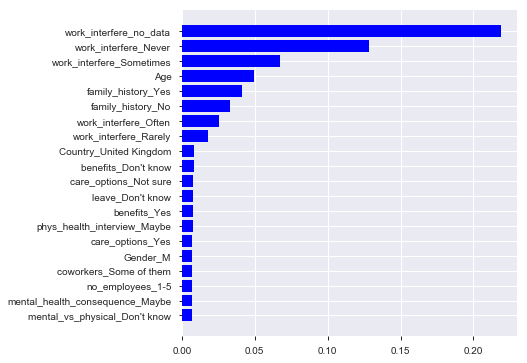

In [13]:
df_exp = df.drop(['treatment'], axis=1)
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['元データ'] = classifiers(X_train, X_test, y_train, y_test, 5)

ランダムフォレストでの影響度を見ると、work_inference、family_history、Ageの有効性が比較的大きいことがわかる。

### ３項目抽出
work_inference、family_history、Ageのみで認識器を作成する。

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ニューラルネット
377/377 [==============================] - 0s 149us/step
Test Accuracy =  0.7692307689145642
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.7931034482758621

決定木
Train Accuracy = 0.8335233751425314 {'max_features': 0.8, 'max_depth': 5}
Test Accuracy: 0.7851458885941645

バギング
Train Accuracy = 0.8403648802736602 {'max_features': 0.6, 'max_samples': 0.4, 'n_estimators': 30}
Test Accuracy: 0.7931034482758621

ランダムフォレスト
Train Accuracy = 0.8095781071835804 {'max_features': 0.6, 'n_estimators': 30}
Test Accuracy: 0.7798408488063661

アダブースト
Train Accuracy = 0.8050171037628279 {'learning_rate': 0.4, 'n_estimators': 50}
Test Accuracy: 0.7771883289124668

K近傍法
Train Accuracy = 0.7765108323831242 {'n_neighbors': 12}
Test Accuracy: 0.7427055702917772

SVM
Train Accuracy = 0.8380843785632839 {'C': 2.0}
Test Accuracy: 0.7931034482758621

ランダムフォレストにおける各項目の影響度
Score:  0.7692307692307693


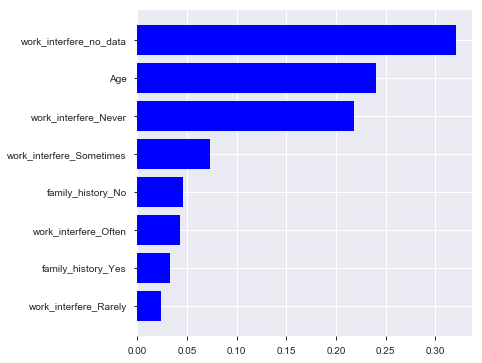

In [14]:
df_exp = df.loc[:,['work_interfere', 'family_history', 'Age']]
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['３項目抽出'] = classifiers(X_train, X_test, y_train, y_test, 5)

ほとんど変わらず。ほかの項目の有無はランダムフォレスト以外の認識器でも影響が小さいということか。

### 従業員数を数値化
今は従業員数がカテゴリ変数になっているが、大小関係や比率が有効かもしれないと考え、数値化した。
数値は1000未満は真ん中の値、1000より多いものは仮に1500とした。

ニューラルネット


C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


377/377 [==============================] - 0s 172us/step
Test Accuracy =  0.578249337344334
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.8090185676392573

決定木
Train Accuracy = 0.8369441277080958 {'max_features': 0.8, 'max_depth': 5}
Test Accuracy: 0.7877984084880637

バギング
Train Accuracy = 0.8460661345496009 {'max_features': 0.6, 'max_samples': 0.4, 'n_estimators': 100}
Test Accuracy: 0.8037135278514589

ランダムフォレスト
Train Accuracy = 0.8392246294184721 {'max_features': 0.6, 'n_estimators': 30}
Test Accuracy: 0.7957559681697612

アダブースト
Train Accuracy = 0.758266818700114 {'learning_rate': 0.8, 'n_estimators': 30}
Test Accuracy: 0.7241379310344828

K近傍法
Train Accuracy = 0.645381984036488 {'n_neighbors': 5}
Test Accuracy: 0.6790450928381963

SVM
Train Accuracy = 0.7251995438996579 {'C': 2.0}
Test Accuracy: 0.7347480106100795

ランダムフォレストにおける各項目の影響度
Score:  0.7957559681697612


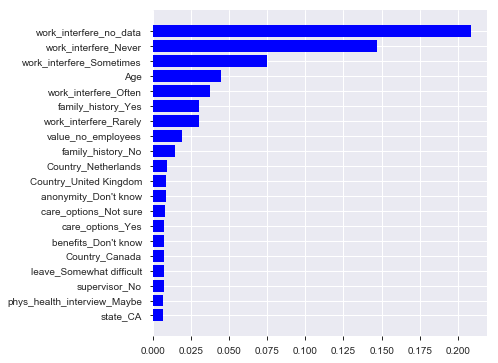

In [15]:
#従業員数を量的データに変換
df_proc = df.copy()
df_proc['value_no_employees'] = 0
df_proc.loc[df_proc['no_employees'] == '1-5', 'value_no_employees'] = 3
df_proc.loc[df_proc['no_employees'] == '6-25', 'value_no_employees'] = 16
df_proc.loc[df_proc['no_employees'] == '26-100', 'value_no_employees'] = 63
df_proc.loc[df_proc['no_employees'] == '100-500', 'value_no_employees'] = 300
df_proc.loc[df_proc['no_employees'] == '500-1000', 'value_no_employees'] = 750
df_proc.loc[df_proc['no_employees'] == 'More than 1000', 'value_no_employees'] = 1500
df_exp = df_proc.drop(['treatment', 'no_employees'], axis=1)
df_res = df_proc['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['従業員数を数値化'] = classifiers(X_train, X_test, y_train, y_test, 5)

精度が悪化した。ランダムフォレストの重要度をみると、従業員数が上位に来ているので、影響度は上がったようだが、逆効果か。

## 結果
各データセット、各認識器でのTest Accuracyを下表に示す。

In [16]:
index_ = []
cols = [[],[],[],[],[],[],[],[]]
for key in results.keys():
    index_.append(key)
    for i, method in enumerate(results[key].keys()):
        cols[i].append(results[key][method])
df_results = pd.DataFrame({},index=index_)
for i, method in enumerate(results['元データ'].keys()):
    df_results[method] = cols[i]
df_results

,アダブースト,決定木,ロジスティック回帰,ランダムフォレスト,バギング,SVM,ニューラルネット,K近傍法
元データ,0.729443,0.771883,0.801061,0.806366,0.801061,0.787798,0.655172,0.668435
３項目抽出,0.777188,0.785146,0.793103,0.779841,0.793103,0.793103,0.769231,0.742706
従業員数を数値化,0.724138,0.787798,0.809019,0.795756,0.803714,0.734748,0.578249,0.679045


どれも80%弱の精度が出ているが、データセット調整および手法の違いによって精度を向上できなかった。  
特に、ロジスティック回帰が比較的優位な精度を出している点が不可解である。  

### ニューラルネットのパラメータ調べ
NNについてハイパーパラメータを調べていないので、以下手当たり次第に実施する。  
対象データセットは比較的精度は良かった"３項目抽出"を使用する。

In [27]:
df_exp = df.loc[:,['work_interfere', 'family_history', 'Age']]
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
y_train_ = []
for tmp in y_train:
    if tmp == 1:
        y_train_.append([0, 1])
    else:
        y_train_.append([1, 0])
y_train = pd.DataFrame(y_train_)
y_test_ = []
for tmp in y_test:
    if tmp == 1:
        y_test_.append([0, 1])
    else:
        y_test_.append([1, 0])
y_test = pd.DataFrame(y_test_)

model = Sequential([
    Dense(500, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(300),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, verbose=1, epochs=100, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Train on 789 samples, validate on 88 samples
Epoch 1/100
789/789 [==============================] - 1s 711us/step - loss: 1.1236 - acc: 0.4575 - val_loss: 0.6837 - val_acc: 0.5568
Epoch 2/100
789/789 [==============================] - 0s 89us/step - loss: 0.6926 - acc: 0.5260 - val_loss: 0.6775 - val_acc: 0.5568
Epoch 3/100
789/789 [==============================] - 0s 130us/step - loss: 0.6906 - acc: 0.5729 - val_loss: 0.6771 - val_acc: 0.7386
Epoch 4/100
789/789 [==============================] - 0s 79us/step - loss: 0.7112 - acc: 0.5120 - val_loss: 0.6860 - val_acc: 0.4432
Epoch 5/100
789/789 [==============================] - 0s 139us/step - loss: 0.6708 - acc: 0.5868 - val_loss: 0.7152 - val_acc: 0.4432
Epoch 6/100
789/789 [==============================] - 0s 89us/step - loss: 0.6815 - acc: 0.5678 - val_loss: 0.6619 - val_acc: 0.6818
Epoch 7/100
789/789 [==============================] - 0s 137us/step - loss: 0.6835 - acc: 0.5741 - val_loss: 0.6564 - val_acc: 0.5568
Epoch 8/100
7

789/789 [==============================] - 0s 103us/step - loss: 0.5970 - acc: 0.6743 - val_loss: 0.5458 - val_acc: 0.7159
Epoch 62/100
789/789 [==============================] - 0s 93us/step - loss: 0.5411 - acc: 0.7313 - val_loss: 0.5857 - val_acc: 0.7159
Epoch 63/100
789/789 [==============================] - 0s 81us/step - loss: 0.5683 - acc: 0.7199 - val_loss: 0.4779 - val_acc: 0.8182
Epoch 64/100
789/789 [==============================] - 0s 80us/step - loss: 0.5875 - acc: 0.7275 - val_loss: 0.4974 - val_acc: 0.7955
Epoch 65/100
789/789 [==============================] - 0s 81us/step - loss: 0.5655 - acc: 0.7250 - val_loss: 0.5894 - val_acc: 0.7159
Epoch 66/100
789/789 [==============================] - 0s 132us/step - loss: 0.5544 - acc: 0.7300 - val_loss: 0.6089 - val_acc: 0.7045
Epoch 67/100
789/789 [==============================] - 0s 78us/step - loss: 0.5342 - acc: 0.7630 - val_loss: 0.4697 - val_acc: 0.8295
Epoch 68/100
789/789 [==============================] - 0s 86us/st

In [28]:

X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
y_train_ = []
for tmp in y_train:
    if tmp == 1:
        y_train_.append([0, 1])
    else:
        y_train_.append([1, 0])
y_train = pd.DataFrame(y_train_)
y_test_ = []
for tmp in y_test:
    if tmp == 1:
        y_test_.append([0, 1])
    else:
        y_test_.append([1, 0])
y_test = pd.DataFrame(y_test_)

model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=20, verbose=0, epochs=200, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


377/377 [==============================] - 0s 111us/step
Test Accuracy =  0.7877984081718586


In [29]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.01, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=200, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 56us/step
Test Accuracy =  0.7957559678535563


In [30]:
model = Sequential([
    Dense(500, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(400),
    Activation('relu'),
    Dense(300),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.01, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=200, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 205us/step
Test Accuracy =  0.77453580727944


In [31]:
model = Sequential([
    Dense(500, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(400),
    Activation('relu'),
    Dense(300),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 48us/step
Test Accuracy =  0.7904509280657579


In [32]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 53us/step
Test Accuracy =  0.7931034493825796


In [33]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 140us/step
Test Accuracy =  0.7692307689145642


In [34]:
model = Sequential([
    Dense(40, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(40),
    Activation('relu'),
    Dense(20),
    Activation('relu'),
    Dense(20),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 56us/step
Test Accuracy =  0.7374005287648512


In [36]:
model = Sequential([
    Dense(40, input_shape=(len(X_train.columns),)),
    Activation('sigmoid'),
    Dense(40),
    Activation('sigmoid'),
    Dense(20),
    Activation('sigmoid'),
    Dense(20),
    Activation('sigmoid'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 56us/step
Test Accuracy =  0.4933687001071495


sigmoidなので勾配消失しているのか？  
層を減らして実施。

In [37]:
model = Sequential([
    Dense(40, input_shape=(len(X_train.columns),)),
    Activation('sigmoid'),
    Dense(20),
    Activation('sigmoid'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=500, validation_split=0.1)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])

377/377 [==============================] - 0s 111us/step
Test Accuracy =  0.5888594169199308


ある程度改善した。  

構造を大きくすることで精度は上がったが、それでもロジスティック回帰とほとんど変わらない。